# Medindo a mobilidade de urbana em Maceió

In [1]:
# Run this cell only once

# apt update -y && apt upgrade -y && apt autoremove -y
# apt install -y libspatialindex-dev

# conda install -y basemap

# pip install -r requirements.txt

In [2]:
%config IPCompleter.greedy=True

import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

In [3]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from pandana.loaders import osm
from geopy.distance import geodesic
from matplotlib import interactive
import folium as folium
# interactive(True)

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

plt.rcParams['figure.dpi'] = 75
mpl.rcParams['figure.figsize'] = (12,12)

/opt/conda/lib/python3.6/socket.py:657: ResourceWarning: unclosed <socket.socket fd=46, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('192.168.48.3', 58738), raddr=('130.117.76.9', 443)>
  self._sock = None
/opt/conda/lib/python3.6/site-packages/osmnx/core.py:344: DeprecationWarning: Flags not at the start of the expression '//(?s)(.*?)/'
  domain = re.findall(r'//(?s)(.*?)/', url)[0]


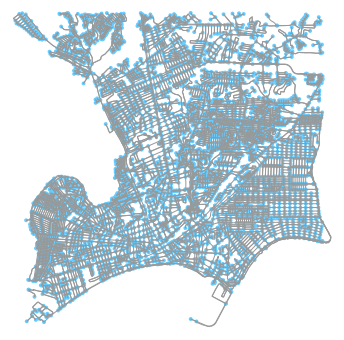

In [4]:
%matplotlib inline
distance = 4000
city_address = 'Maceió, Alagoas'
G = ox.graph_from_address(city_address,distance = distance)
cityGraph, axes = ox.plot_graph(G)


In [5]:
# getting positions
lats = []
lngs = []

nv = G.nodes
for item in nv.items():
  lats.append(item[1]['y'])
  lngs.append(item[1]['x'])
 
lng_min = min(lngs)
lat_min = min(lats)

lng_max = max(lngs)
lat_max = max(lats)

bbox = [lat_min, lng_min, lat_max, lng_max]

In [6]:
# define your selected amenities and bounding box
amenities = ['hospital', 'school']
amenity = 'school'

# request them from the OpenStreetMap API (Overpass)
pois = osm.node_query(lat_min, lng_min, lat_max, lng_max)

# loading walkable way into a network
network = osm.pdna_network_from_bbox(lat_min, lng_min, lat_max, lng_max)

pois = pois[pois['amenity'].isin(amenities)]

#List how many we downloaded
pois[['amenity', 'name', 'lat', 'lon']].head()

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](-9.68327010,-35.76979940,-9.61155870,-35.69751890);>;);out;'}"
Downloaded 2,675.7KB from www.overpass-api.de in 3.31 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 3.36 seconds
Returning OSM data with 16,444 nodes and 4,994 ways...
Edge node pairs completed. Took 9.02 seconds
Returning processed graph with 7,203 nodes and 10,590 edges...
Completed OSM data download and Pandana node and edge table creation in 13.08 seconds


/opt/conda/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),


,amenity,name,lat,lon
id,,,,
635114211,hospital,Hospital Sanatório,-9.627268,-35.743635
741595292,school,NaN,-9.618086,-35.725054
747126244,school,CPEC,-9.637543,-35.699649
796002423,school,NaN,-9.652937,-35.730961
796372966,hospital,NaN,-9.657961,-35.731303


In [7]:
# couting by amenity
pois_counts = pois.amenity.value_counts()
pd.DataFrame(pois_counts)

,amenity
school,30
hospital,10


In [8]:
# calculating distance
# nodes_tuples = list(zip(lats, lngs))
# pois_tuples  = list(zip(pois['lat'].values,pois['lon'].values))


# # print("{0} X {1}".format(node_size, poi_size))
# # geodesic(nodes_tuples[0], pois_tuples[0]).kilometers
# distance_matrix = []
# for node in nodes_tuples:
#   distance_array = []
#   for poi in pois_tuples:
#     distance_array.append(geodesic(node, poi).kilometers * 1000)
#   distance_array.sort()
#   distance_matrix.append(distance_array)

In [9]:
# pd.DataFrame(distance_matrix)

In [10]:
# setting 1KM as max distance
distance = 1000

# creating network layer by category
for amenity in amenities:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, maxdist = distance, maxitems= len(pois_subset), x_col=pois_subset['lon'], y_col=pois_subset['lat'])

# creating network layer for all categories
network.set_pois(category='all', maxdist = distance, maxitems= len(pois), x_col=pois['lon'], y_col=pois['lat'])


/opt/conda/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/opt/conda/lib/python3.6/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [11]:
#plotting hexbin
def plot_nearest_amenity_hexbin(amenity, distance, n):
    accessibility = network.nearest_pois(distance = distance, category=amenity, num_pois= n)
    basemap,fig, ax = network.plot(accessibility[n], bbox=bbox, plot_type='hexbin', fig_kwargs = {'figsize': [15, 15]} ,
                                                                bmap_kwargs={'suppress_ticks': False,'resolution': 'l'},
                                                                plot_kwargs={'cmap': 'BrBG', 'edgecolor': 'none'})
    ax.set_facecolor('k')
    ax.set_title('Mapa de proximidade em metros de {} (Categoria: {}, pontos de interesse: {})'.format(city_address,amenity,n), fontsize=14)
    
# plotting scatter plot
def plot_nearest_amenity_scatter(amenity, distance, n):
    accessibility = network.nearest_pois(distance = distance, category=amenity, num_pois= n)
    basemap,fig, ax = network.plot(accessibility[n], bbox=bbox, fig_kwargs = {'figsize': [15, 15]} ,
                                                                bmap_kwargs={'suppress_ticks': False,'resolution': 'l'},
                                                                plot_kwargs={'cmap': 'BrBG', 's': 8, 'edgecolor': 'none'})
    ax.set_facecolor('k')
    ax.set_title('Mapa de proximidade em metros de {} (Categoria: {}, pontos de interesse: {})'.format(city_address,amenity,n), fontsize=14)


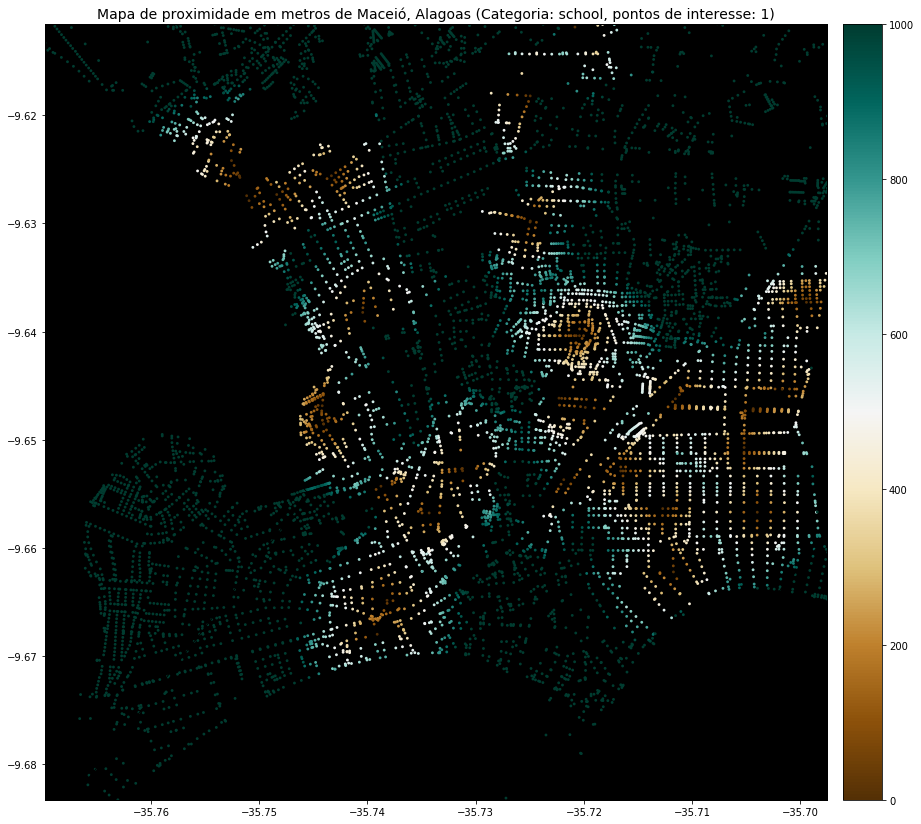

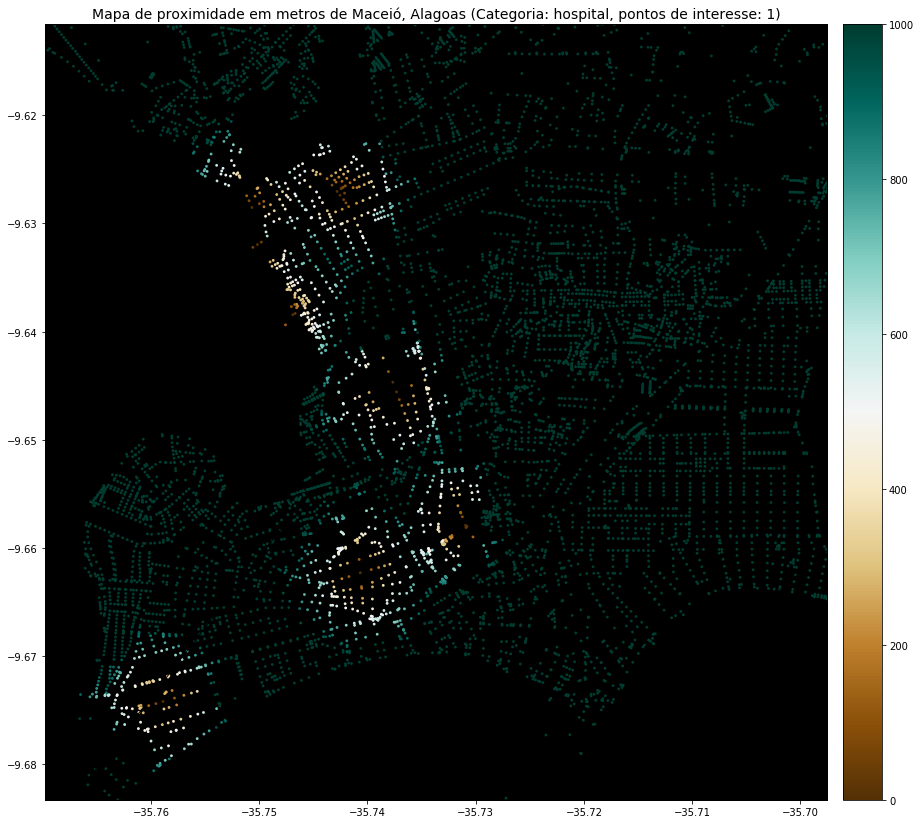

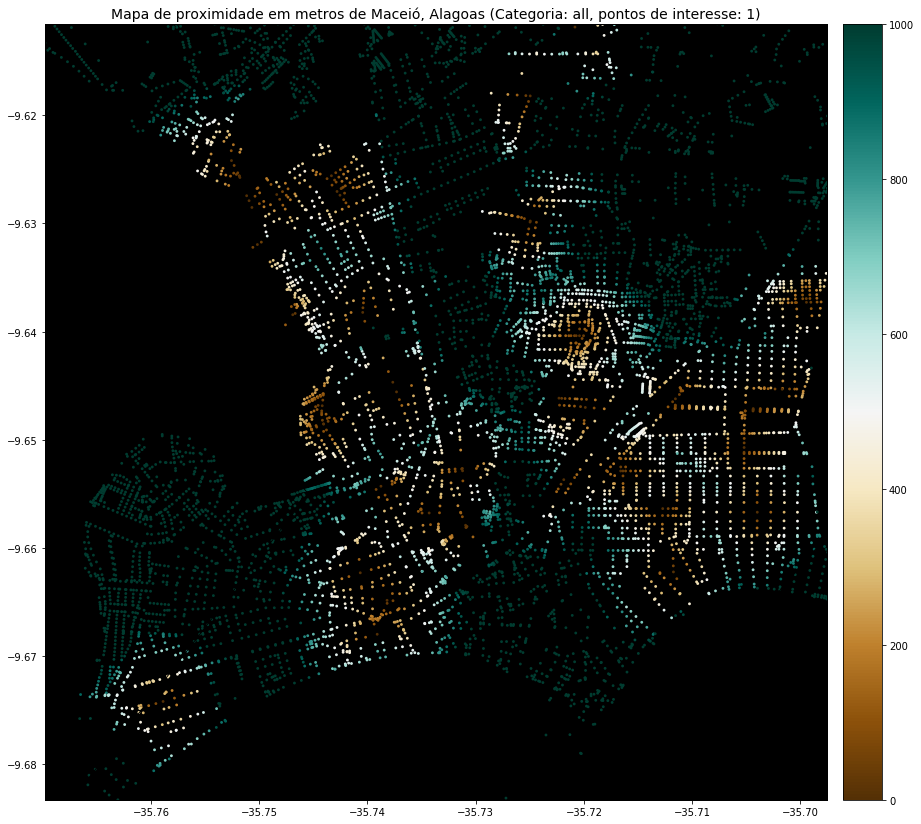

In [12]:
%matplotlib inline

plot_nearest_amenity_scatter('school', 1000,1)
plot_nearest_amenity_scatter('hospital',1000,1)
plot_nearest_amenity_scatter('all', 1000,1)


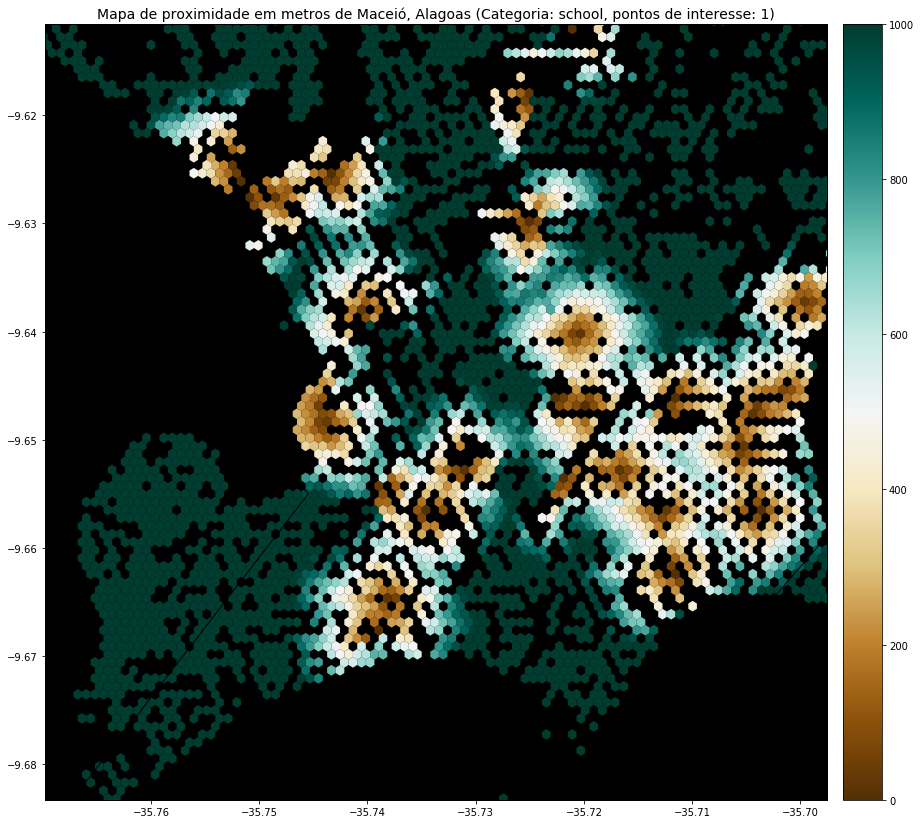

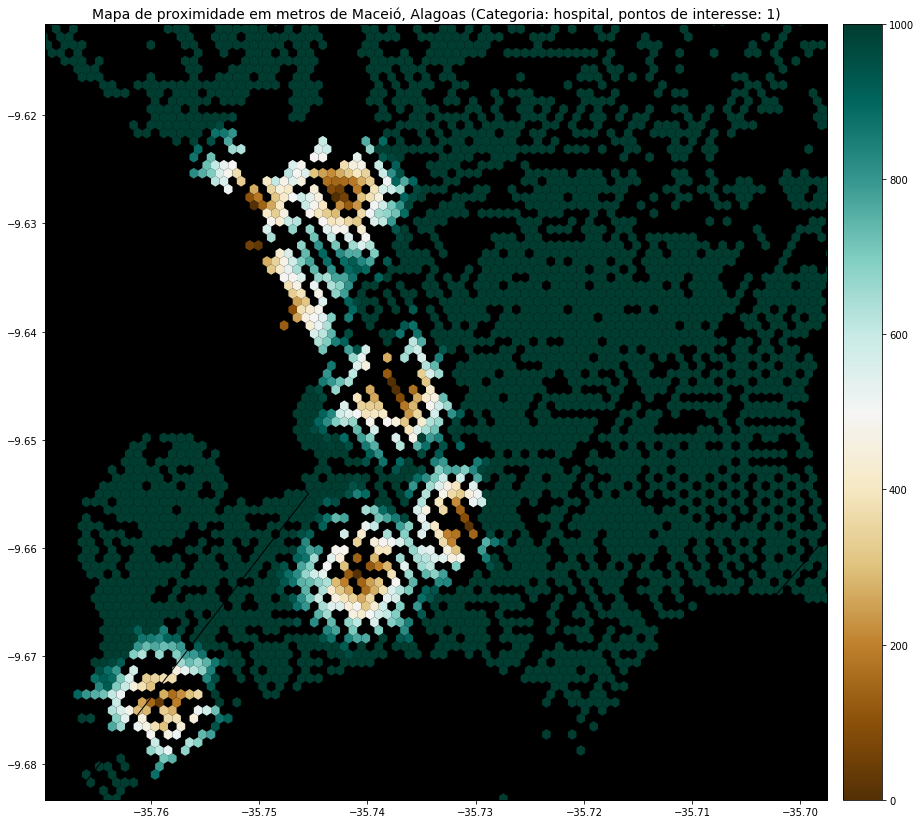

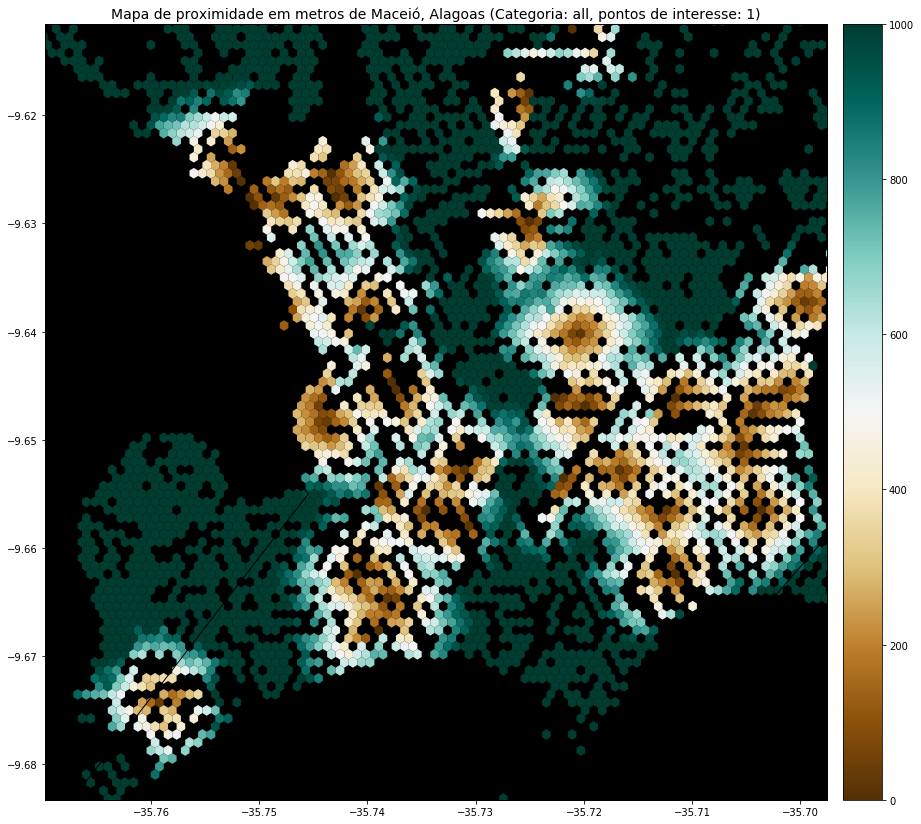

In [13]:
plot_nearest_amenity_hexbin('school',1000,1)
plot_nearest_amenity_hexbin('hospital',1000,1)
plot_nearest_amenity_hexbin('all',1000,1)

## Referências

https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56